# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [71]:
import sys
print(sys.version)

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


In [72]:
data_dir = './data'

%load_ext autoreload
%autoreload 2

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

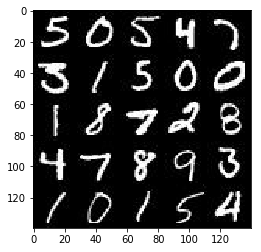

In [73]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

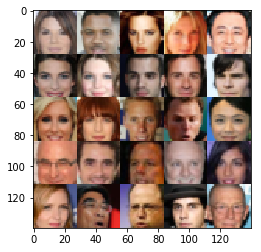

In [74]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [76]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32,  name='learning_rate')
    return input_real, input_z, learning_rate


#"""
#DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
#"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [77]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28xD -> 14x14x64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)

        # 14x14x64 -> 7x7x128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)

        # 7x7x128 -> 4x4x256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # flatten
        f = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(f, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [78]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [79]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [92]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [96]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [97]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha = 0.2, smooth=0.1)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # rescale images to [-1, 1]
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.2419... Generator Loss: 17.3947
Epoch 1/2... Discriminator Loss: 2.0047... Generator Loss: 4.3343
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 3.0909
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 2.1518
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 6.7329
Epoch 1/2... Discriminator Loss: 0.6076... Generator Loss: 3.7802
Epoch 1/2... Discriminator Loss: 0.4482... Generator Loss: 3.3120
Epoch 1/2... Discriminator Loss: 2.2901... Generator Loss: 0.3386
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 1.7807


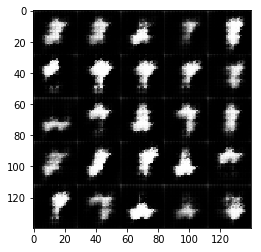

Epoch 1/2... Discriminator Loss: 0.5765... Generator Loss: 1.9594
Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 2.3992
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 2.3994
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 2.6893
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.3164
Epoch 1/2... Discriminator Loss: 0.6712... Generator Loss: 3.6265
Epoch 1/2... Discriminator Loss: 0.7407... Generator Loss: 1.5523
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 2.6758
Epoch 1/2... Discriminator Loss: 0.5280... Generator Loss: 2.4457
Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 1.4275


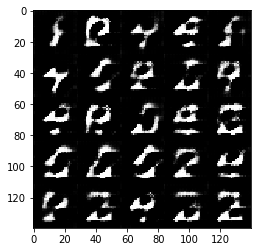

Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 3.2974
Epoch 1/2... Discriminator Loss: 0.6570... Generator Loss: 1.6806
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 3.1633
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 3.2177
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 2.4111
Epoch 1/2... Discriminator Loss: 0.6815... Generator Loss: 2.5351
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.0184


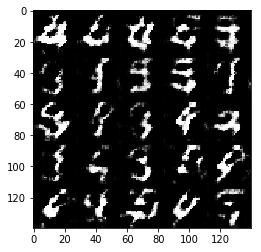

Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.8801
Epoch 1/2... Discriminator Loss: 0.9599... Generator Loss: 1.3740
Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 1.8846
Epoch 1/2... Discriminator Loss: 1.8910... Generator Loss: 0.5177
Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 1.4841
Epoch 1/2... Discriminator Loss: 0.7878... Generator Loss: 1.6865
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.1767
Epoch 1/2... Discriminator Loss: 0.7253... Generator Loss: 1.4874
Epoch 1/2... Discriminator Loss: 0.8801... Generator Loss: 1.3631


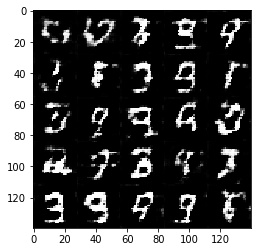

Epoch 1/2... Discriminator Loss: 0.8942... Generator Loss: 1.8997
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 1.3502
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 1.0070
Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 1.1518
Epoch 1/2... Discriminator Loss: 1.9889... Generator Loss: 3.6542
Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 1.0474
Epoch 1/2... Discriminator Loss: 0.9091... Generator Loss: 1.0700
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.8421
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.9420
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.7773


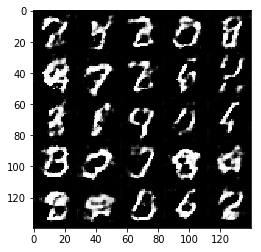

Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.4299
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 1.0097
Epoch 1/2... Discriminator Loss: 0.9220... Generator Loss: 2.0868
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.6846
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 1.7836
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 3.1654


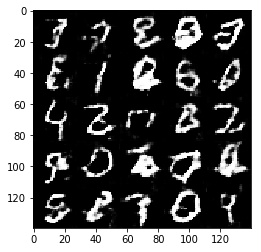

Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.0810
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.9724
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 1.7279
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 1.3362
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.6350
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 1.4290
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 1.0345
Epoch 1/2... Discriminator Loss: 1.5785... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.6271


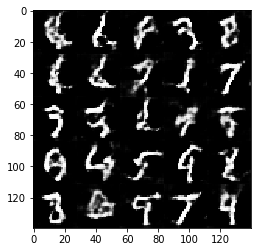

Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 1.0904
Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 1.3413
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 1.3240
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 2.9697
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.6450
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 1.3119
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 1.8503
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.7004


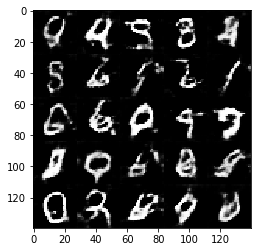

Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 1.9081
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 1.8248
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 1.0499
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 1.0810
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.4871
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 1.2065
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.8632
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 1.0435
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 2.1752


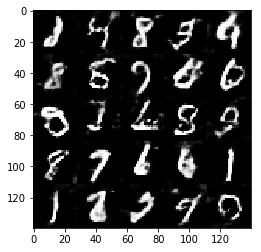

Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 1.2245
Epoch 2/2... Discriminator Loss: 0.9788... Generator Loss: 1.9768
Epoch 2/2... Discriminator Loss: 1.1696... Generator Loss: 1.0375
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 1.7139
Epoch 2/2... Discriminator Loss: 1.5286... Generator Loss: 0.4620
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 1.6172
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.7033


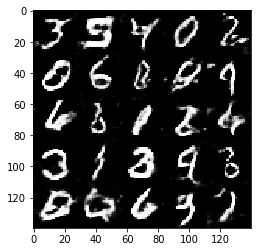

Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 2.0208
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 1.0118
Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 2.0838
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 2.3625
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.8907
Epoch 2/2... Discriminator Loss: 1.9663... Generator Loss: 0.3235
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 0.9313
Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 1.4919


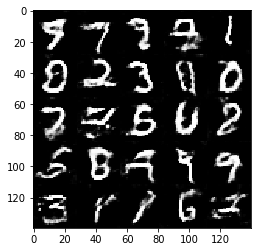

Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 1.7622
Epoch 2/2... Discriminator Loss: 0.9218... Generator Loss: 1.4295
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.4779... Generator Loss: 2.1654
Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 1.1375
Epoch 2/2... Discriminator Loss: 1.5277... Generator Loss: 0.5124
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 1.4020
Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 2.3148


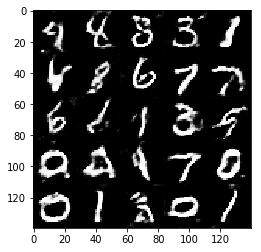

Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 1.4116
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.5548... Generator Loss: 0.4293
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 1.1102
Epoch 2/2... Discriminator Loss: 1.1776... Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.7369


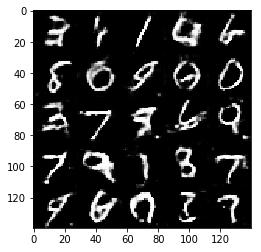

Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 2.3409
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 1.4419
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.6762
Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 1.1803
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 0.8269
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 0.8183


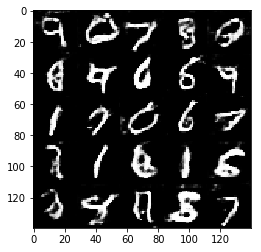

Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 0.7603
Epoch 2/2... Discriminator Loss: 3.2854... Generator Loss: 4.7127
Epoch 2/2... Discriminator Loss: 1.5675... Generator Loss: 0.4966
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 0.9984
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 2.5747
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 1.3014
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 0.8798


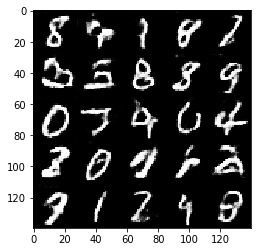

Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 1.4284
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 1.0819
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.5580
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 1.7363
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 1.4588
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.6882


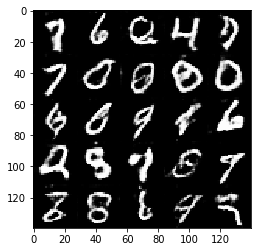

Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.7783... Generator Loss: 0.3471
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 0.8143... Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.4622
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.3251
Epoch 2/2... Discriminator Loss: 1.6511... Generator Loss: 0.5500
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 1.2992
Epoch 2/2... Discriminator Loss: 0.7882... Generator Loss: 1.5620
Epoch 2/2... Discriminator Loss: 1.9094... Generator Loss: 3.3527


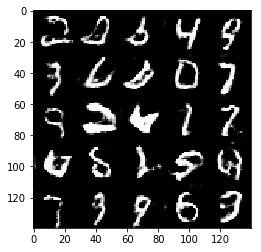

Epoch 2/2... Discriminator Loss: 1.1751... Generator Loss: 0.9562
Epoch 2/2... Discriminator Loss: 0.9419... Generator Loss: 1.2903
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 1.0529
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 2.4254
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 1.5560... Generator Loss: 0.5599
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.9896
Epoch 2/2... Discriminator Loss: 1.2470... Generator Loss: 1.7782


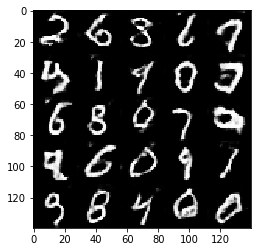

Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.1163... Generator Loss: 1.6254
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 1.8142
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 1.7755
Epoch 2/2... Discriminator Loss: 1.0256... Generator Loss: 1.1031
Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 2.2960
Epoch 2/2... Discriminator Loss: 0.9479... Generator Loss: 1.6095


In [98]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.5887... Generator Loss: 11.9595
Epoch 1/1... Discriminator Loss: 2.7265... Generator Loss: 0.2383
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.6540
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.9829
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.9038
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 2.4779


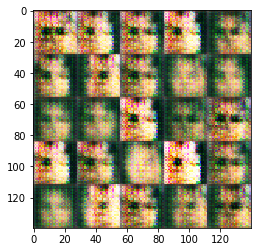

Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 2.8507
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 2.1195
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 2.2923
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 2.9425
Epoch 1/1... Discriminator Loss: 1.9500... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.0428


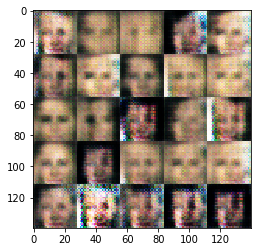

Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 2.0209
Epoch 1/1... Discriminator Loss: 1.7798... Generator Loss: 2.2580
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7751


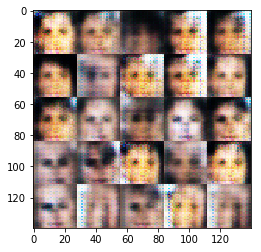

Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.7706... Generator Loss: 2.3471
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 2.2844... Generator Loss: 3.0625


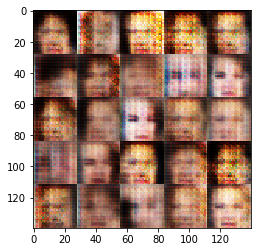

Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 2.8868... Generator Loss: 3.6570
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 1.1059


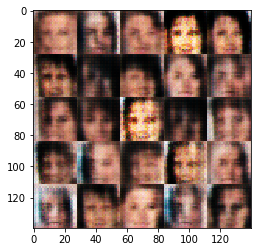

Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 1.9639
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.4387


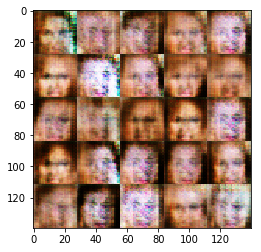

Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 2.6763... Generator Loss: 3.8610
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7907


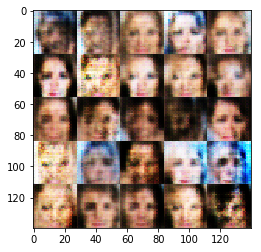

Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 1.8369... Generator Loss: 0.3387
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 1.4965
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 2.0211... Generator Loss: 2.6417
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.5473
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.9363


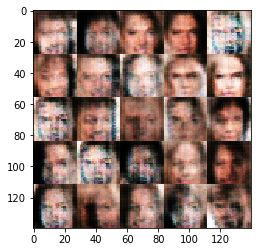

Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 1.7164
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.8879
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.4081


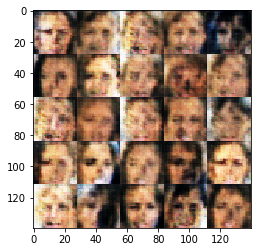

Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 2.0077
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 2.0716
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.4749
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.9461


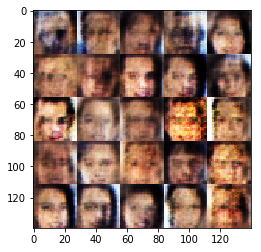

Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.6727... Generator Loss: 2.2885
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.4272
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.5443
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.1689


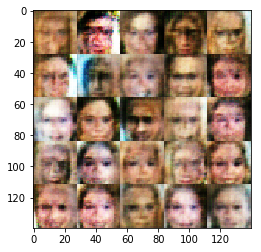

Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.8324


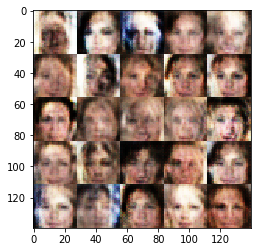

Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.3542
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.7018
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.5998
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.5092


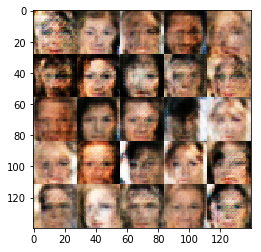

Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 2.3461
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 1.9708
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.5343
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.4627
Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 1.9263... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.0934


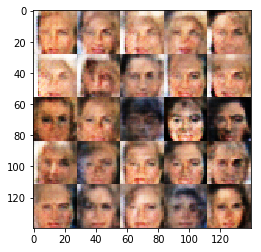

Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8848


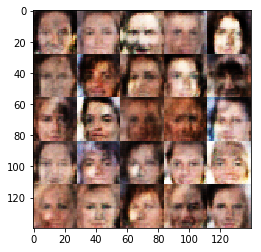

Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 2.0725... Generator Loss: 3.3446
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 1.6069
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.2172


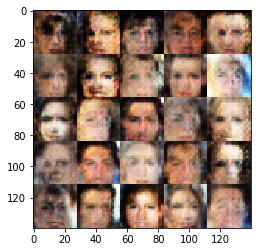

Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.6376
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.6088
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.3871


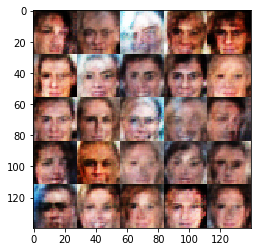

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 2.1683
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 1.3212
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.6776
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.1453


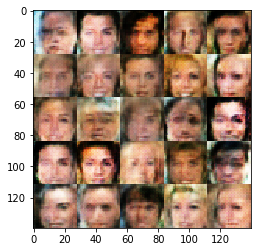

Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.8087


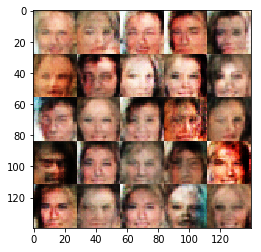

Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.0337


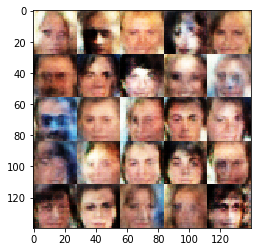

Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 2.2099
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 0.4019
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.9031


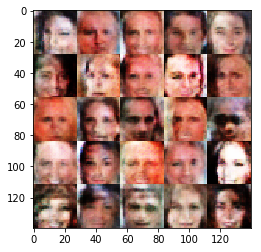

Epoch 1/1... Discriminator Loss: 1.9211... Generator Loss: 0.2817
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 2.3591
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 1.8267... Generator Loss: 0.3261
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8443


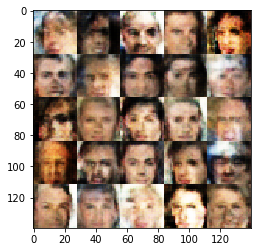

Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 2.0622
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.3542
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6431


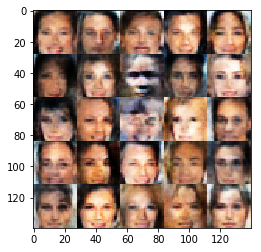

Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.6071
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.5819
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.4764


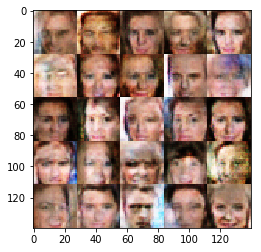

Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.8544
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.4773
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.8297


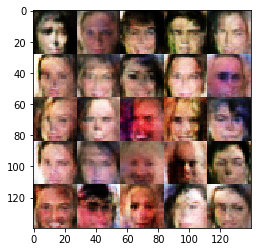

Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.6415
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.6809
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.3090
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5060


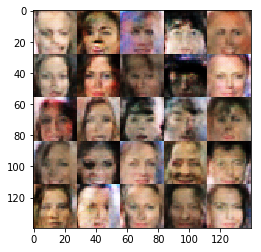

Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7050


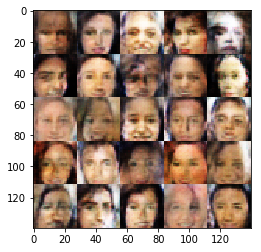

Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.5049
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.8805
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.6330


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.